In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gmixo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
train_df.head(10)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']
# check missing values in numeric columns
train_df.describe()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


In [6]:
# check for any 'null' comment in train set
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)


0

In [7]:
# check for any null comment in test set
no_comment_test = test_df[test_df['comment_text'].isnull()]
len(no_comment)

0

In [8]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [9]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

In [10]:
data = train_df[cols_target]

<AxesSubplot:title={'center':'Correlation of features & targets'}>

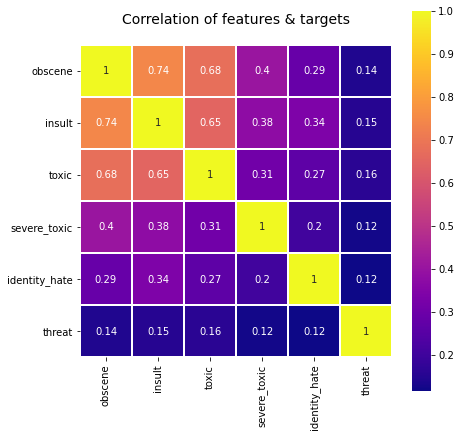

In [11]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
   ### removing non-word characters
    text = re.sub('[^A-Za-z\' ]+', '',text)                                        ### removing all non-alphanumeric values(Except single quotes)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = ' '.join([word for word in text.split() if word not in(stop_words)])    ### Stopwords removal
    return text

In [13]:
# clean the comment_text in train_df 
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))
# clean the comment_text in test_df 
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

In [14]:
train_df = train_df.drop('char_length',axis=1)

In [15]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

vect

TfidfVectorizer(max_features=10000, stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [16]:
X_train = train_df.comment_text
y_train = train_df[cols_target]
X_test = test_df.comment_text
test_df.head()
print(X_test.shape, X_train.shape)

(153164,) (159571,)


In [17]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_train_tf = vect.fit_transform(X_train)

# examine the document-term matrix created from X_train
X_train_tf

<159571x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 3346834 stored elements in Compressed Sparse Row format>

In [18]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
X_test_tf = vect.transform(X_test)
# examine the document-term matrix from X_test
X_test_tf

<153164x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2813940 stored elements in Compressed Sparse Row format>

Label Powerset. This method transforms the problem into a multi-class problem where the multi-class labels are essentially all the unique label combinations. In our case here, where there are six labels, Label Powerset would in effect turn this into a 2^6 or 64-class problem.

In [19]:
from keras.models import Sequential
from keras.layers import Dense

KERAS_PARAMS = dict(epochs=10, batch_size=100, verbose=0)

def create_model_multiclass(input_dim, output_dim):
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.ext import Keras

clf = LabelPowerset(classifier=Keras(create_model_multiclass, True, KERAS_PARAMS), require_dense=[True,True])
print(clf)


In [23]:
y_pred = clf.predict((X_train_tf) > 0.5).astype("int32")

In [26]:
clf.fit(X_train_tf,y_train)


In [27]:

from sklearn import metrics
print("Training accuracy is  = ", metrics.accuracy_score( y_train.to_numpy(), y_pred))


Training accuracy is  =  0.9044939243346222
